# Understanding and visualizing attack optimization

In this notebook, we show how the SecML library can be used to understand the attack optimization process better and to properly tune the attack hyperparameters (e.g., step size and number of iterations).
We consider the targeted evasion of the DeepNeural Network ResNet18 trained on ImageNet. 

## Load the pretrained model
We load the pre-trained ResNet18 model from `torchvision`,  and we pass it to the `secml` wrapper.  

In [1]:
from torchvision import models
import torch
import numpy as np
from secml.data import CDataset
from secml.ml.classifiers import CClassifierPyTorch
from secml.ml.features import CNormalizerMeanStd

# Set random seed for pytorch and numpy
torch.manual_seed(0)
np.random.seed(0)

# Download and cache pretrained model from the torchvision model zoo
model = models.resnet18(pretrained=True)

# imagenet normalization
normalizer = CNormalizerMeanStd(mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225))

# wrap the model, including the normalizer
clf = CClassifierPyTorch(model=model,                
                         input_shape=(3, 224, 224),
                         softmax_outputs=False,
                         preprocess=normalizer,
                         random_state=0)

We load the image of a race car that we would like to have misclassified as a tiger.

In [2]:
from PIL import Image
import requests
import io
from secml.array import CArray
from torchvision import transforms
# Only required for visualization in notebooks
%matplotlib inline

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),         
])

img_path = "https://images.pexels.com/photos/589782/pexels-photo-589782.jpeg"\
            "?cs=srgb&dl=car-mitshubishi-race-rally-589782.jpg&fm=jpg"
r = requests.get(img_path)
img = Image.open(io.BytesIO(r.content))

# apply transform from torchvision
img = transform(img)
# transform the image into a vector
img = torch.unsqueeze(img, 0).view(-1)
img = CArray(img.numpy())

We create a function that we will use to show the source and the adversarial images.

In [3]:
from secml.figure import CFigure
import numpy as np


def plot_img(x, label):
    fig = CFigure(height=4, width=4, fontsize=14)
    x = np.transpose(x.tondarray().reshape((3, 224, 224)),
                     (1, 2, 0))
    fig.sp.title(label)
    fig.sp.imshow(x)
    fig.show()

We show the original image.

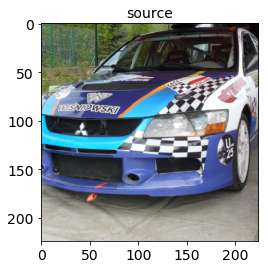

In [4]:
plot_img(img, label='source')

We check if the classifier is able to assign the correct label (race car) to this image.

In [5]:
# load the imagentet labels
import json
imagenet_labels_path = "https://raw.githubusercontent.com/" \
                       "anishathalye/imagenet-simple-labels/" \
                       "master/imagenet-simple-labels.json"
r = requests.get(imagenet_labels_path)
labels = json.load(io.StringIO(r.text))

# get the classifier prediction
preds = clf.predict(img)
pred_class = preds.item()
pred_label = labels[pred_class]
print("predicted label : {:}".format(pred_label))

predicted label : race car


We should create the attack class that we will use to compute the attack. Changing the value of the variable `attack_type`, you can choose between three different attacks: CW, PGD, and PGD-patch. 

CW: Run the Carlini Wagner attack modifying the full image.\
PGD: Run the PGD attack modifying the full image.\
PGD-patch: Run the PGD attack modifying only a restricted region of the image. This attack may take some seconds to run.

In [6]:
attack_type = 'PGD-patch'

In case we would like to perform a PGD-patch we need to define the upper bound and the lower bound of the attack accordingly.
We create a function ad-hoc for this goal.

In [7]:
def define_lb_ub(img, x_lb, x_ub, y_lb, y_ub, lb, ub,n_channels=3):
    
    # reshape the img (it is stored as a flat vector)
    img = img.tondarray().reshape((3, 224, 224))

    # assign to the lower and upper bound the same values of the image pixels
    lb_patch = deepcopy(img)
    ub_patch = deepcopy(img)

    # for each image channel, set the lower bound of the pixels in the region defined by x_lb, x_ub,
    # y_lb, y_ub equal to lb and the upper bound equal to up
    # in this way the attacker will be able to modify only the pixels in this region.
    for ch in range(n_channels):
         lb_patch[ch, x_lb:x_ub, y_lb:y_ub] = lb
         ub_patch[ch, x_lb:x_ub, y_lb:y_ub] = ub

    # make the upper and lower bound flat vectors
    lb_patch = np.ravel(lb_patch)
    ub_patch = np.ravel(ub_patch)

    # transform them in CArray
    lb_patch = CArray(lb_patch)
    ub_patch = CArray(ub_patch)

    return lb_patch, ub_patch

We create the object that we will use to run the attack.

In [8]:
from secml.adv.attacks import CAttackEvasion
from cleverhans.attacks import CarliniWagnerL2
from secml.data import CDataset
from copy import deepcopy

lb = 0 
ub = 1
target_idx = 292 # tiger 

if attack_type == "CW":
    attack_code = 'e-cleverhans'
    attack_params = {'max_iterations': 50, 'learning_rate': 0.005, 
                     'binary_search_steps': 1, 'confidence': 1e6,
                     'abort_early': False, 'initial_const': 0.4,
                     'n_feats': 150528, 'n_classes': 1000,
                     'y_target': target_idx,
                     'clip_min': lb, 'clip_max': ub,
                     'clvh_attack_class': CarliniWagnerL2}
    
elif attack_type == 'PGD':
    attack_code = 'e-pgd'
    solver_params = {
        'eta': 1e-2, 
        'max_iter': 50,
        'eps': 1e-6}
    attack_params = {'distance': 'l2',
                     'dmax': 1.875227,
                     'lb': lb,
                     'ub': ub,
                     'y_target': target_idx,
                     'solver_params': solver_params}

elif attack_type == 'PGD-patch':
    attack_code = 'e-cleverhans'
    # create the mask that we will use to allows the attack to modify only a restricted region of the image
    # define the mask dimension
    x_lb = 140; x_ub = 160; y_lb = 10; y_ub = 80
    dmax_patch = 5000
    lb_patch, ub_patch = define_lb_ub(img, x_lb, x_ub, y_lb, y_ub, lb,ub,n_channels=3)
    attack_code = 'e-pgd'
    solver_params = {
        'eta': 0.8,
        'max_iter': 50,
        'eps': 1e-6}

    attack_params = {'distance': 'l2',
                     'dmax': dmax_patch,
                     'lb': lb_patch,
                     'ub': ub_patch,
                     'y_target': target_idx,
                     'solver_params': solver_params}
val = CDataset(img, pred_class)
attack = CAttackEvasion.create(attack_code, clf, surrogate_classifier=clf,surrogate_data=val,**attack_params)

We run the attack.

In [9]:
eva_y_pred, _, eva_adv_ds, _ = attack.run(img, pred_class)

To understand if the attack hyperparameters that we have chosen were correct, we can analyze some useful debugging plot. In particular, we can check how the loss and the confidence in the prediction of the target class (solid line) and the true class (dotted line) changes during the attack.

We check if the classifier misclassifies this image as a tiger.

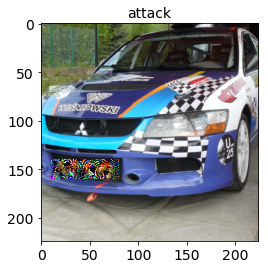

predicted label : race car


In [10]:
adv_img = eva_adv_ds.X[0,:]

plot_img(adv_img, label='attack')

# get the classifier prediction
advx_pred = clf.predict(adv_img)
advx_label_idx = advx_pred.item()
adv_predicted_label = labels[advx_label_idx]
print("predicted label : {:}".format(adv_predicted_label))

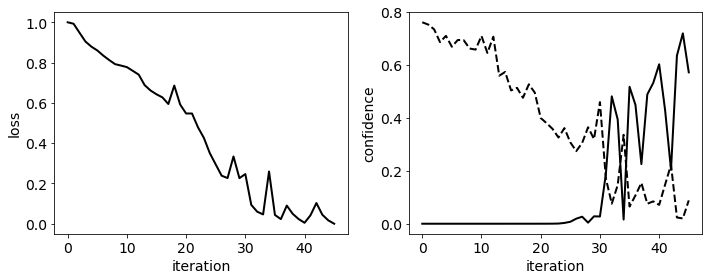

In [13]:
from secml.ml.classifiers.loss import CSoftmax
from secml.ml.features.normalization import CNormalizerMinMax

n_iter = CArray(attack.f_seq).size
itrs = CArray.arange(n_iter)

# create a subplot that shows the loss during the attack iterations

# apply a linear scaling to have the loss in [0,1]
loss = attack.f_seq
loss = CNormalizerMinMax().fit_transform(CArray(loss).T).ravel()

fig = CFigure(width=10, height=4, fontsize=14, linewidth=2)

fig.subplot(1, 2, 1)
fig.sp.xlabel('iteration')
fig.sp.ylabel('loss')
fig.sp.plot(itrs, loss,c='black')

# create a subplot that shows the confidence during the attack iterations

# classify all the points in the attack path
scores = clf.predict(loss, return_decision_function=True)[1]

# we apply the sofrmax to the score to have value in [0,1]
scores = CSoftmax().softmax(scores)

fig.subplot(1, 2, 2)
fig.sp.xlabel('iteration')
fig.sp.ylabel('confidence')
fig.sp.plot(itrs, scores[:,pred_class], 
            linestyle='--', c='black')
fig.sp.plot(itrs, scores[:,target_idx],c='black')

fig.tight_layout()
fig.show()

Finally, we can show the explanations of the attack image that highlights which features the classifier considers as important to classify this image as the tiger class.

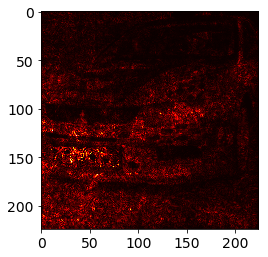

In [12]:
from secml.explanation import CExplainerIntegratedGradients

fig = CFigure(height=4, width=4, fontsize=14)

# compute the explanations w.r.t. the target class
explainer = CExplainerIntegratedGradients(clf)
expl = explainer.explain(adv_img, y=target_idx, m=300)

# show the explanations
expl = np.transpose(expl.tondarray().reshape((3, 224, 224)),
                    (1, 2, 0))
r = np.fabs(expl[:, :, 0])
g = np.fabs(expl[:, :, 1])
b = np.fabs(expl[:, :, 2])

# Calculate the maximum error for each pixel
expl = np.maximum(np.maximum(r, g), b)

fig.sp.imshow(expl, cmap='hot')